<a href="https://colab.research.google.com/github/JackGraymer/Advanced-GenAI/blob/main/2.1_rag_research_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Generative Artificial Intelligence
**Project - Designing a RAG-Based Q&A System for News Retrieval**

**Authors:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan (Group 5)


# Step 2.1 - Building the RAG System: Research Agents -<br> Implementing multiple pre-retrieval and retrieval strategies

**Contribution:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan

**Goal of this step:** Implementing and comparing diﬀerent pre-retrieval and retrieval strategies to extract relevant candidate documents. These retrieved documents will go through the post-retrieval process in Step 2.2.

#  1. Data Preprocessing and Benchmark Construction

## 1.1 Setup of the environment

### Installations and loading of packages

Below the necessary libraries are installed and loaded into the environment.

In [23]:
import os
import re
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from langchain.text_splitter import RecursiveCharacterTextSplitter
import pprint

### Setting seeds and mounting Google Drive storage folder

In [2]:
# Set the seed for consistent results
seed_value = 2138247234
random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

Below we mount a shared Google Drive folder as a data storage and define the base path of the folder that will be used in the runtime.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_folder = '/content/drive/MyDrive/AdvGenAI'

### Check properties of environment

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.6.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.6
ale-py                                0.11.0
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.0.2
astropy-iers-data                     0.2025.5.12.0.38.29
astunparse                            1

## 1.2 Loading the dataset from stage 1

In [ ]:
df = pd.read_csv(os.path.join(base_folder, 'Stage1/Final-Datasets/Stage1-final.csv'))

In [ ]:
df.head()

,folder_path,file_name,year,month,language,type,title,content,named_entities,topics,keywords,summary
0,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,"Als 1950 die Meteorologen Jule Charney, Ragnar...","[('CO2', 'MISC'), ('Klimamodelle\n\n', 'PER'),...","['klimamodelle', 'prozesse', 'modelle', 'gitte...","['wetterprognose', 'wettermodellen', 'precipit...","Geht es aber darum, wie häufig heisse und glei..."
1,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,scientifica-teaser-kerosin-aus-luft.html,2019,8,de,news events,Scientifica teaser kerosin aus luft,"Vieles, womit sich Wissenschaftlerinnen und Wi...","[('Schweiz', 'LOC'), ('Scientifica', 'LOC'), (...","['science', 'scientifica', 'wissenschaftlerinn...","['wissenschaftsfestival', 'wissenschaftlerinne...","Vieles, womit sich Wissenschaftlerinnen und Wi..."
2,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kraftwerk-vor-dem-fenster.html,2019,8,de,news events,Kraftwerk vor dem fenster,Gebäude zu heizen oder zu kühlen benötigt Ener...,"[('Komfort', 'LOC'), ('Nature Energy 4', 'MISC...","['fassade', 'energie', 'gebäude', 'raum', 'pro...","['energiesparpotenzial', 'gebäudesysteme', 'so...",Die Wirkung der adaptiven Solarfassade wird Sc...
3,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,eth-plus-initiativen.html,2019,8,de,news events,Eth plus initiativen,"Das Interesse an ETH+, in dessen Rahmen bereit...","[('Zentrum', 'ORG'), ('ETH', 'ORG'), ('ETH Zür...","['eth', 'professur', 'zusammenarbeit', 'bereic...","['ausgezeichneten', 'eth', 'elektronengetriebe...","Das Interesse an ETH+, in dessen Rahmen bereit..."
4,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kuenstliche-intelligenz-im-podcast.html,2019,8,de,news events,Kuenstliche intelligenz im podcast,Künstliche Intelligenz und maschinelles Lernen...,"[('Benjamin Grewe', 'PER'), ('ETH Zürich', 'OR...","['intelligenz', 'sprechen', 'science', 'maschi...","['technologien', 'künstlichen', 'künstliche', ...",Im Podcast sprechen wir mit den ETH-Professore...


Below we plot the dataframe sorted by the length of the `content` column. We will remove the rows where the content is less than 45 characters, since those texts don't provide any useful information.

In [ ]:
print(df.shape)

(4351, 12)


In [ ]:
# sort df by lenght of context ascending
df.sort_values(by='content', key=lambda x: x.str.len(), ascending=True).head(10)

,folder_path,file_name,year,month,language,type,title,content,named_entities,topics,keywords,summary
1143,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,medienmitteilung-stop-hate-speech-alliance-f-u...,2023,2,de,news events,Medienmitteilung stop hate speech alliance f u...,## Kontakt,[],['kontakt'],['kontakt'],## Kontakt
4081,/content/drive/MyDrive/AdvGenAI/data/en_news_e...,medienmitteilung-stop-hate-speech-alliance-f-u...,2023,2,en,news events,Medienmitteilung stop hate speech alliance f u...,## Contact,"[('## Contact', 'MONEY')]",['contact'],['contact'],## Contact
1705,/content/drive/MyDrive/AdvGenAI/data/de_intern...,mendeley-literaturverwaltung.html,2014,1,de,internal,Mendeley literaturverwaltung,Weitere Informationen\n\n,[],['informationen'],"['weitere', 'informationen']",Weitere Informationen
1749,/content/drive/MyDrive/AdvGenAI/data/de_intern...,citavi-literaturverwaltung.html,2014,2,de,internal,Citavi literaturverwaltung,Weitere Informationen\n\n,[],['informationen'],"['weitere', 'informationen']",Weitere Informationen
1704,/content/drive/MyDrive/AdvGenAI/data/de_intern...,web-of-science-alles-neu-macht-der--januar-.html,2014,1,de,internal,Web of science alles neu macht der januar,Weitere Informationen\n\n,[],['informationen'],"['weitere', 'informationen']",Weitere Informationen
2262,/content/drive/MyDrive/AdvGenAI/data/de_intern...,usa-fulbright-specialist-program.html,2024,6,de,internal,Usa fulbright specialist program,Siehe Details auf der englischen Webseite.,"[('englischen', 'MISC')]","['details', 'englischen', 'siehe', 'webseite']","['webseite', 'englischen', 'siehe', 'auf', 'der']",Siehe Details auf der englischen Webseite.
2217,/content/drive/MyDrive/AdvGenAI/data/de_intern...,usa-fulbright-specialist-program.html,2024,1,de,internal,Usa fulbright specialist program,Siehe Details auf der englischen Webseite.,"[('englischen', 'MISC')]","['details', 'englischen', 'webseite', 'siehe']","['webseite', 'englischen', 'siehe', 'auf', 'der']",Siehe Details auf der englischen Webseite.
2549,/content/drive/MyDrive/AdvGenAI/data/en_intern...,had-enough-of-long-training-courses.html,2014,10,en,internal,Had enough of long training courses,The events take place from 12.15 to 12.30:\n\n,"[('12.30', 'CARDINAL'), ('12.15', 'CARDINAL')]","['events', 'place']","['events', '12', '15', '30', 'place']",The events take place from 12.15 to 12.30:
1740,/content/drive/MyDrive/AdvGenAI/data/de_intern...,tablets-fuer-studium-und-arbeit--betriebssyste...,2014,4,de,internal,Tablets fuer studium und arbeit betriebssystem...,Themen:\n\nWeitere Informationen und Anmeldung...,[],"['anmeldung', 'informationen', 'themen']","['informationen', 'weitere', 'anmeldung', 'the...",Themen: Weitere Informationen und Anmeldung
1399,/content/drive/MyDrive/AdvGenAI/data/de_intern...,together-2018.html,2018,9,de,internal,Together 2018,## Impressionen\n\nBilder: ETH Zürich / Alessa...,"[('Alessandro Della Bella\n\n', 'PER'), ('ETH ...","['alessandro', 'bella', 'bilder', 'della', 'et...","['zürich', 'impressionen', 'alessandro', 'dell...",## Impressionen Bilder: ETH Zürich / Alessandr...


In [ ]:
df = df[df['content'].str.len() > 45]
print(df.shape)

(4343, 12)


For easier handling in the following steps we add an ID for each row starting at "0000" (including leading zeros).

In [ ]:
df = df.reset_index(drop=True)
df.insert(0, 'text_id', df.index.astype(str).str.zfill(4))

In [ ]:
df.head()

,text_id,folder_path,file_name,year,month,language,type,title,content,named_entities,topics,keywords,summary
0,0000,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,"Als 1950 die Meteorologen Jule Charney, Ragnar...","[('CO2', 'MISC'), ('Klimamodelle\n\n', 'PER'),...","['klimamodelle', 'prozesse', 'modelle', 'gitte...","['wetterprognose', 'wettermodellen', 'precipit...","Geht es aber darum, wie häufig heisse und glei..."
1,0001,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,scientifica-teaser-kerosin-aus-luft.html,2019,8,de,news events,Scientifica teaser kerosin aus luft,"Vieles, womit sich Wissenschaftlerinnen und Wi...","[('Schweiz', 'LOC'), ('Scientifica', 'LOC'), (...","['science', 'scientifica', 'wissenschaftlerinn...","['wissenschaftsfestival', 'wissenschaftlerinne...","Vieles, womit sich Wissenschaftlerinnen und Wi..."
2,0002,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kraftwerk-vor-dem-fenster.html,2019,8,de,news events,Kraftwerk vor dem fenster,Gebäude zu heizen oder zu kühlen benötigt Ener...,"[('Komfort', 'LOC'), ('Nature Energy 4', 'MISC...","['fassade', 'energie', 'gebäude', 'raum', 'pro...","['energiesparpotenzial', 'gebäudesysteme', 'so...",Die Wirkung der adaptiven Solarfassade wird Sc...
3,0003,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,eth-plus-initiativen.html,2019,8,de,news events,Eth plus initiativen,"Das Interesse an ETH+, in dessen Rahmen bereit...","[('Zentrum', 'ORG'), ('ETH', 'ORG'), ('ETH Zür...","['eth', 'professur', 'zusammenarbeit', 'bereic...","['ausgezeichneten', 'eth', 'elektronengetriebe...","Das Interesse an ETH+, in dessen Rahmen bereit..."
4,0004,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kuenstliche-intelligenz-im-podcast.html,2019,8,de,news events,Kuenstliche intelligenz im podcast,Künstliche Intelligenz und maschinelles Lernen...,"[('Benjamin Grewe', 'PER'), ('ETH Zürich', 'OR...","['intelligenz', 'sprechen', 'science', 'maschi...","['technologien', 'künstlichen', 'künstliche', ...",Im Podcast sprechen wir mit den ETH-Professore...


In [ ]:
# save dataset
df.to_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-01-loaded-dataset.csv'), index=False)

## 1.3 Chunking of the news texts

In [ ]:
# Load dataset
df = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-01-loaded-dataset.csv'))

In this section we chunk our contents into smaller chunks. There are many different chunking methods. Since the text are in a markdown structure we will define a chunker that utilizes the properties of the markdown format by splitting the documents before the section headers.

After this splitting, not all parts have a reasonable length. Therefore we first merge chunks that are too small with the proceeding chunk. After that we go through the chunks and split those that are too large using a `RecursiveCharacterTextSplitter` with a defined chunk overlap. Since this Splitter might return chunks smaller than the defined minimum we had to rerun the step of adding too small chunks to previous ones and as a last step splitting the chunks that are too large into two parts with an added overlap.

The minimal length of a chunk should be set so is long enough to contain information and meaning. For the maximum length we look back at previous projects. For example in CLT we built upon an existing RAG pipeline by Daniel Perruchoud and George Rowlands ([Github](https://github.com/LuciferUchiha/Cleantech-RAG/tree/main)). There a maximum length of 1024 characters showed good results.

Since the chunks will be used for embeddings it makes sense to look at the model cards and especially the Intended uses and the training we can discover that many sentence embedding models were trained with a context length of 256 tokens, even though some allow an input of 512 or more tokens when using the models. Others will simply trunctuate at 256 tokens. With an average length of 4 characters per token we get 1024 characters, therefore in general allowing the use of the whole context of the chunk for the embedding.

After trying different settings we decide on a min. chunk size of 150 characters, max. chunk size of 1000 characters and a chunk overlap of 200 characters (if recursive splitting is necessary).

In [ ]:
import re
from typing import List
# Assuming RecursiveCharacterTextSplitter is available from langchain.text_splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter

class HierarchicalRecursiveTextSplitter:
    def __init__(self, min_chunk_size=150, max_chunk_size=1000, chunk_overlap=200):
        self.min_chunk_size = min_chunk_size
        self.max_chunk_size = max_chunk_size
        self.chunk_overlap = chunk_overlap
        self.recursive_splitter = RecursiveCharacterTextSplitter(
            separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""],
            chunk_size=self.max_chunk_size,
            chunk_overlap=self.chunk_overlap,
            length_function=len,
        )

    def split_by_header(self, text: str) -> List[str]:
        # Use multiline matching to split on header lines starting with '## '
        pattern = re.compile(r'(^## .+$)', flags=re.MULTILINE)
        splits = pattern.split(text)

        chunks = []
        # The first element of splits is the text before the first header
        if splits[0] and splits[0].strip():
            chunks.append(splits[0].strip())

        # Iterate through the rest, pairing header with its content
        for i in range(1, len(splits), 2):
            header = splits[i].strip()
            content = splits[i + 1].strip() if (i + 1) < len(splits) else ""
            chunk_text = f"{header}\n{content}".strip()
            if chunk_text:
                chunks.append(chunk_text)

        # Clean up excessive newlines
        for i in range(len(chunks)):
            chunks[i] = re.sub(r'\n{2,}', '\n', chunks[i])
        return chunks

    def recursive_split(self, chunks: List[str]) -> List[str]:
        final_chunks = []
        for chunk in chunks:
            if len(chunk) > self.max_chunk_size:
                # Recursively split large chunks
                smaller_chunks = self.recursive_splitter.split_text(chunk)
                final_chunks.extend(smaller_chunks)
            else:
                final_chunks.append(chunk)
        return final_chunks

    def merge_small_chunks(self, chunks: List[str]) -> List[str]:
        n = len(chunks)
        if n < 2:
            return chunks

        processed_chunks = []
        # --- Step 1: Handle the first two chunks (chunks[0] and chunks[1])
        first_chunk = chunks[0]
        second_chunk = chunks[1]
        # If either the first or the second chunk (or both) is small...
        if len(first_chunk) < self.min_chunk_size or len(second_chunk) < self.min_chunk_size:
            processed_chunks.append(first_chunk + "\n" + second_chunk)
        else:
            # Neither the first nor the second chunk is small. Add them separately.
            processed_chunks.append(first_chunk)
            processed_chunks.append(second_chunk)

        # --- Step 2: Loop for remaining chunks (from index 2 onwards)
        for i in range(2, n):
            current_chunk = chunks[i]
            # Check if the current chunk is smaller than the minimum required size.
            if len(current_chunk) < self.min_chunk_size:
                processed_chunks[-1] = processed_chunks[-1] + "\n" + current_chunk
            else:
                # Current chunk is not small. Add it as a new chunk.
                processed_chunks.append(current_chunk)
        return processed_chunks

    def split_too_large_chunks(self, chunks: List[str]) -> List[str]:
        final_chunks = []
        for chunk in chunks:
            if len(chunk) > self.max_chunk_size:
                mid_point = len(chunk) // 2
                overlap_half = self.chunk_overlap // 2
                start_of_second_chunk = mid_point - overlap_half
                end_of_first_chunk = mid_point + overlap_half
                chunk1 = chunk[:end_of_first_chunk]
                chunk2 = chunk[start_of_second_chunk:]
                final_chunks.extend([chunk1, chunk2])
            else:
                final_chunks.append(chunk)
        return final_chunks

    def split_text(self, text: str) -> List[str]:
        # 1. Split hierarchically by header
        header_chunks = self.split_by_header(text)
        # 2. Merge small chunks to enforce min_chunk_size.
        merged_chunks = self.merge_small_chunks(header_chunks)
        # 3. Recursively split any chunks that are too large.
        split_chunks = self.recursive_split(merged_chunks)
        # 4. Merge small chunks again to clean up after recursive splitting.
        final_merged_chunks = self.merge_small_chunks(split_chunks)
        # 5. Split any remaining oversized chunks as a final step.
        final_chunks = self.split_too_large_chunks(final_merged_chunks)

        return final_chunks

In [ ]:
splitter = HierarchicalRecursiveTextSplitter()

for j in range(5):
  print(f"--- Document {j+1} ---")
  chunks = splitter.split_text(df["content"].iloc[j])

  for i, chunk in enumerate(chunks):
      print(f"--- Chunk {i+1} ---")
      print(chunk)
      print()

--- Document 1 ---
--- Chunk 1 ---
Als 1950 die Meteorologen Jule Charney, Ragnar Fjørtoft und der Mathematiker John von Neumann zusammen mit anderen Forschenden erstmals am Computer das Wetter simulierten, brauchten sie 24 Stunden Rechenzeit, um eine Prognose für 24 Stunden Wetter zu erstellen. Die Voraussage war dürftig, die Realität war schon eingetroffen und damit die Voraussage für niemanden brauchbar. Heute ist die Wetterprognose erstaunlich gut, oft bis eine Woche im Voraus und für extreme Ereignisse. Sie ist auf jedem Telefon verfügbar, und alle wissen, wie sie zu interpretieren ist.

--- Chunk 2 ---
## Erstaunliche Entwicklung der Klimamodelle
Auch die eng mit Wettermodellen verwandten Klimamodelle haben eine erstaunliche Entwicklung durchlaufen. Sie simulieren heute die Strömungen in der Atmosphäre und im Ozean, das Meereis, die Biosphäre und das Land, den Kohlenstoffkreislauf und vieles mehr. Klimamodelle berücksichtigen Tausende von Rückkopplungen und Prozesse des Klimas, u

Looking through the chunks on a subset of the data (see hidden output above) the separation of the hirarchie and the splitting up of the longer chunks (with overlapping text) looks satisfactory.

Therefore we decide to apply this chunking method on our whole dataframe.

In [ ]:
def create_chunked_dataframe(df, splitter):
    chunked_data = []

    for idx, row in df.iterrows():
        chunks = splitter.split_text(row['content'])

        for chunk_idx, chunk_text in enumerate(chunks):
            chunk_data = {
                'text_id': str(row['text_id']).zfill(4),  # Ensure leading zeros
                'chunk_id': f"{chunk_idx:02d}",
                'unique_chunk_id': f"{str(row['text_id']).zfill(4)}_{chunk_idx:02d}",  # Also fix here
                'chunk_text': chunk_text,
                'chunk_length': len(chunk_text),
                'total_chunks': len(chunks),
                # Copy all other original columns
                **{col: row[col] for col in df.columns if col not in ['content', 'text_id']}
            }
            chunked_data.append(chunk_data)

    return pd.DataFrame(chunked_data)

In [ ]:
# Define splitter and chunk the whole dataset
splitter = HierarchicalRecursiveTextSplitter()
chunked_df = create_chunked_dataframe(df, splitter)

In [ ]:
# Change column order
column_order = [
    'unique_chunk_id',   # Global unique identifier
    'chunk_text',        # The actual chunk content
    'chunk_length',      # Length of chunk
    'total_chunks',      # How many chunks in this document
    'folder_path',
    'file_name',
    'year',
    'month',
    'language',
    'type',
    'title',
    'text_id',           # Original document ID
    'chunk_id',          # Chunk number within document
]

chunked_df = chunked_df[column_order]

In [ ]:
chunked_df.head()

,unique_chunk_id,chunk_text,chunk_length,total_chunks,folder_path,file_name,year,month,language,type,title,text_id,chunk_id
0,0000_00,"Als 1950 die Meteorologen Jule Charney, Ragnar...",563,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,00
1,0000_01,## Erstaunliche Entwicklung der Klimamodelle\n...,804,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,01
2,0000_02,"«Alle Modelle sind falsch, aber einige sind nü...",881,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,02
3,0000_03,"Doch um die Gitterweite verkleinern zu können,...",536,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,03
4,0000_04,Bis ein hochaufgelöstes Modell auf einer neuen...,466,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0000,04


In [ ]:
chunked_df.shape

(28072, 13)

We receive a total number of approximately 28'000 chunks (an average of 6.5 chunks per text).

Below we plot a histogram of the chunks length. They all lie in the region between the defined minimium and maximum size, with some exception on the smaller side. When checking those chunks we find as expected that those are chunks that contain the whole text, therefore no merging into a larger neighboring chunk was possible.

Text(0.5, 1.0, 'Distribution of Chunk Lengths')

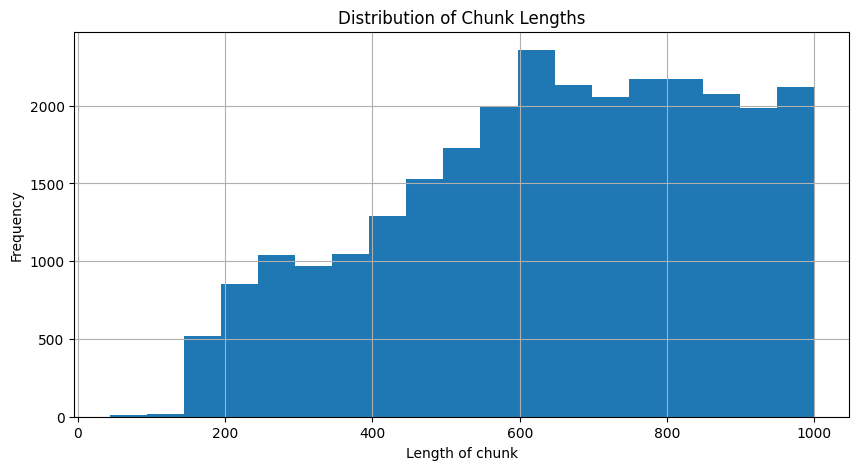

In [ ]:
chunked_df['chunk_length'].hist(bins = 19, figsize=(10, 5), grid = True)
plt.xlabel('Length of chunk')
plt.ylabel('Frequency')
plt.title('Distribution of Chunk Lengths')

In [ ]:
chunked_df[chunked_df['chunk_length'] < 100]

,unique_chunk_id,chunk_text,chunk_length,total_chunks,folder_path,file_name,year,month,language,type,title,text_id,chunk_id
10985,1398_00,## Impressionen\nBilder: ETH Zürich / Alessand...,59,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,together-2018.html,2018,9,de,internal,Together 2018,1398,00
11716,1548_00,#GewusstWie – Die Infrastruktur und die Tools ...,90,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,how-to-publish-your-research-data-in-the-resea...,2019,11,de,internal,How to publish your research data in the resea...,1548,00
12041,1659_00,Die ETH Zürich holt zusammen mit dem VSETH und...,97,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,gluehweihnachten-auf-dem-hoenggerberg.html,2016,12,de,internal,Gluehweihnachten auf dem hoenggerberg,1659,00
12061,1670_00,Näheres dazu finden Sie imFlyer Ihres Gebäudeb...,74,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,entsorgungswoche-2016.html,2016,10,de,internal,Entsorgungswoche 2016,1670,00
12113,1698_00,Geschlossen sind:\n(Grund: interne Veranstaltu...,81,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,abweichende-oeffnungszeiten-freitag-29-august....,2014,8,de,internal,Abweichende oeffnungszeiten freitag 29 august,1698,00
12223,1725_00,Der Zugriff ist online im Netzwerk der ETH Zür...,96,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,neue-zeitschriften-online.html,2014,7,de,internal,Neue zeitschriften online,1725,00
12266,1734_00,Der Zugriff ist online im Netzwerk der ETH Zür...,96,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,neue-zeitschriften.html,2014,4,de,internal,Neue zeitschriften,1734,00
12283,1737_00,Themen:\nWeitere Informationen und Anmeldung,43,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,tablets-fuer-studium-und-arbeit--betriebssyste...,2014,4,de,internal,Tablets fuer studium und arbeit betriebssystem...,1737,00
12285,1739_00,Die Schulung richtet sich an Fortgeschrittene....,90,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,ipad-fuer-studium-und-arbeit-.html,2014,4,de,internal,Ipad fuer studium und arbeit,1739,00
12359,1760_00,Die Veranstaltungen finden jeweils von 12.15 b...,65,1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,keine-lust-auf-lange-schulungen.html,2014,10,de,internal,Keine lust auf lange schulungen,1760,00


In [ ]:
# save dataset
chunked_df.to_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-02-chunked-dataset.csv'), index=False)

## 1.4 Loading of Benchmark Questions and Answers

In [18]:
Questions = """Who was president of ETH in 2003?
Who were the rectors of ETH between 2017 and 2022?
Who at ETH received ERC grants?
When did the InSight get to Mars?
What did Prof. Schubert say about ﬂying?
What is e-Sling?
Who are famous ETH alumni?
Who at ETH currently works on research regarding climate change?
How do alpine plants respond to climate change?
How would you make fertilizer without carbon emissions?
What research is ETH famous for?
How much of ETH’s electricity consumption is due to computing? How did that develop over the years?
What are pseudocereals and who does research on them?
Who is working on methods for targeted cancer treatment, and what do they use?
How is ETH research investigating methods to avoid diarrhea?
What is ETH Plus?
How do birds learn new songs?
What connections does ETH have to Hong Kong?
For how many years has ETH done research on Quantum Computing?
What are the current projections for the student numbers at ETH?
Why should I study at ETH?
Who investigated the catastrophic events in Tibet in 2016, and what was found?
Why should ETH receive any additional funding?
Anybody at ETH doing anything for people with disabilities?
Does ETH organize any competitions?""".split('\n')

In [31]:
Answers = """Olaf Kübler
Sarah Springman, Günther Dissertori
European Research Council grants: Tobias Donner, Eliott Ash, Ursula Keller, Klaus Ensslin, Yiwen Chu, Judit Szuláovi, Sebastino Cantalupo, Veerle Sterken, Rachel Granoe, Paolo Crivelli, Christian Degen, Jonathan Home, Lavinia Heisenberg, Tilman Esslinger, …
26 November 2018
Flying is too cheap. If we want to reduce ﬂying, surcharges on air fares are certainly a step in the right direction.
4-seated electric airplane, built by 20 electrical and mechanical engineering students at ETH Zurich
Wilhelm Conrad Röntgen, Charles-Edouard Guillaume, Albert Einstein, Felix Bloch, Heinrich Rohrer, Georg Bednorz, Karl Alexander Müller, Alfred Werner, Fritz Haber, Richard Ernst, Tadeus Reichstein, Werner Arber, Othmar Ammann, Max Frisch, Rudolf Clausius, Santiago Calatrava, John von Neumann, Maurice Koechlin, Mileva Marić, Richard Kuhn, Albert Heim, Armand Borel, Ferdinand Piëch, Gabriel Narutowicz, Hansjörg Wyss, Kurt Wüthrich, Marcel Grossmann, Eduard Imhof.
ETH Department of Environmental Systems Science, D-USYS, on the research side. Anthony Patt (climate policy) and several researchers (check); Instute for Atmospheric and Climate Science; Chair of Hydrology and Water Resources Development, D-BAUG, NADEL on sustainable development (Jasmine Neve); ETH Net Zero on the institutional side.
Alpine plants are being signiﬁcantly impacted by climate change, primarily due to increasing temperatures that allow lower-elevation species to migrate upward. While many alpine plants can tolerate warming itself, they struggle to compete with faster-growing, larger plants from lower elevations, which are gaining a competitive edge in warmer conditions. This shiw is gradually altering the composition of plant communities, especially at mid-elevations where vegetation is already dense. Resistance from established alpine species and limited seed dispersal slow this process, but over time, as climate warming continues, lower-elevation plants are expected to establish themselves more widely. Experimental studies at ETH suggest that while some alpine plants can survive in future climatic conditions, many are at risk of being outcompeted, leading to signiﬁcant long-term changes in alpine ecosystems.
Reducing carbon emissions in fertilizer production requires shifting away from fossil fuel-based hydrogen and adopting more sustainable alternatives. One method is electrification using renewable energy, where hydrogen is produced via water electrolysis powered by solar or wind energy, eliminating direct emissions but requiring signiﬁcantly more energy. A third option is hydrogen production from biomass, which can be carbon-neutral if using waste materials but competes with food production for land and water. Additionally, improving fertilitier efficiency by reducing overuse and food waste can lower overall demand, while decentralitied production in regions with abundant renewables or biomass can enhance food security. A combination of these strategies, tailored to local conditions, offers the most effective path to decarbonizing fertilizer production, mitigating climate impact while maintaining agricultural productivity.
As a research-intensive university, ETH conducts research across a wide spectrum of disciplines. What are you interested in?
We have very little data on this. In 2017, computing at ETH Zurich produced 13,500 tons of CO2, which is about 10% of the total emissions produced. ETH Zurich consumes about 40 GWh of electricity per year; this number has been increasing over the years. ETH Zurich has the goal of Net-Zero emissions by 2030.
Pseudocereals are plants that are not botanically related to true cereals (such as wheat, rice, or corn) but are cultivated and used in a similar way. They produce storable seeds with grain-like characteristics, making them viable alternatives to traditional cereals. Pseudocereals oﬀer beneﬁts such as diﬀerent pest resistance, high nutritional value, and gluten-free properties. The three most important pseudocereals are buckwheat, quinoa, and amaranth. The Molecular Plant Breeding group at ETH Zurich is working on this.
Researchers across multiple disciplines are actively working on targeted cancer treatments, employing diverse approaches to enhance precision, efficacy, and safety. One group focuses on the development of tumor-targeted radioligands by refining synthetic methodologies. By leveraging solid-phase chemistry, they have created a modular system to construct folate-based radioconjugates. These compounds are designed to target tumors more effectively in radionuclide therapy, optimizing pharmacokinetics while ensuring stability and cost-effectiveness. Their efforts have led to the synthesis of structurally diverse folate conjugates, broadening the possibilities for radioligand-based treatments. Meanwhile, at ETH Zurich, biologist Daniel Richter and his colleagues have devised a method to improve the stability of drug-antibody linkages, ensuring that anti-cancer agents remain intact until they reach tumor cells. Their approach relies on a unique enzyme that modifies proteins in a highly specific manner, enabling the creation of stable and highly targeted antibody-drug conjugates. This innovation not only enhances drug efficacy but also reduces side effects by allowing higher dosages to be administered safely. Their research is laying the foundation for more precise cancer therapies that could significantly improve treatment outcomes. Another team, led by Professor Bernd Bodenmiller at the Tumor Profiler Center, is harnessing big data and precision medicine to personalize cancer treatment. By analyzing spatial images of tumor tissue at the molecular and cellular levels, researchers are generating extensive datasets that reveal unique tumor profiles. These data-driven insights help oncologists tailor therapies to individual patients, leading to more effective and personalized treatment plans. The integration of cutting-edge computational methods with clinical expertise is transforming cancer care, making it more adaptive to each patient's specific disease characteristics. Finally, researchers at Engimmune Therapeutics, an ETH Spin-Off company, are pioneering an approach that redirects immune cells to attack cancer more effectively. Their work focuses on engineering soluble T-cell receptors (TCRs), which recognize tumor-specific intracellular targets—an area previously inaccessible to traditional antibody therapies. By integrating machine learning and protein engineering, they can identify the most effective TCR variants, ensuring precise targeting while minimizing safety risks. Their technology not only enhances the immune system's ability to recognize and destroy cancer cells but also presents a scalable and cost-effective alternative to current immunotherapies.
At ETH Zurich, researchers are uncovering novel ways to combat bacterial intestinal diseases, focusing on how vaccinations can prevent diarrhea and hinder the spread of antibiotic resistance. Led by Senior Assistant Emma Slack, the team has demonstrated that vaccine-induced antibodies in the intestine play a crucial role in stopping bacterial infections before they cause illness. When bacteria such as Salmonella divide in the intestine, vaccine-induced IgA antibodies bind them together, effectively trapping entire bacterial families in clumps. This process, which occurs even at low bacterial densities, prevents the pathogens from attacking intestinal tissue. Instead of killing the bacteria outright—which could trigger an inflammatory immune response—the antibodies prevent their movement and accelerate their removal through excretion. The clumping also blocks genetic exchange between bacteria, a key factor in the spread of antibiotic resistance. The research team tested their approach using oral vaccines made from inactivated Salmonella and E. coli bacteria, and they believe the method could be extended to other harmful pathogens such as Shigella and Listeria. One promising application is in livestock, where antibiotic-resistant bacteria frequently originate. By vaccinating farm animals, the risk of human infections from contaminated meat or farm environments could be significantly reduced.
The expression can have two meanings. "Plus" can stand for Planning Landscape and Urban Settings, an initiative of ETH Zurich's Department of Civil, Environmental and Geomatic Engineering (D-BAUG). It can also mean ETH+, which is a program launched in 2017 by the Executive Board of ETH Zurich. It aims to ensure ETH Zurich retains its leading position into the future and to develop additional capabilities to take new, unconventional approaches in teaching, research as well as knowledge and technology transfer. In 2019, the program was renamed Open ETH.
Songbirds, such as zebra finches, learn new songs through a step-by-step process that mirrors how children acquire language. When exposed to a new song, the birds do not learn it all at once; instead, they adapt syllables they already know to resemble the new ones they must learn. Initially, the sequence of syllables may be jumbled, but in later phases, they rearrange them into the correct order. This incremental learning approach allows songbirds to expand their repertoire efficiently, minimizing effort while maximizing accuracy. Researchers at ETH Zurich have observed this pattern in controlled experiments, where young birds exposed to a changing song gradually modified their vocalizations in a structured way. Interestingly, this learning strategy is similar to methods used in computer linguistics for document comparison. Just as algorithms analyze the similarity between words while disregarding their order, birds modify individual syllables before organizing them properly. This suggests that songbirds have evolved a computationally efficient approach to learning, refining their songs in a way that minimizes cognitive load. Some researchers hypothesize that human infants might employ a similar method when learning new languages, adapting familiar sounds before integrating them into proper linguistic structures. However, further studies are needed to determine whether this minimalist strategy also applies to human language acquisition.
Besides having exchange of students and researchers, ETH Zurich maintains institutional agreements with o Chinese University of Hong Kong - Daegu Gyeongbuk Institute of Science and Technology - ETH Zurich, Joint Research Laboratory on Innovative Nanotechnology for Medicine and Healthcare o Chinese University of Hong Kong (CUHK), Chow Yuk Ho Technology Centre for Innovative Medicine (Multi-Scale Robotics Lab). o Hong Kong University of Science and Technology, Schools of Engineering & Science Recently, ETH Zurich and CUHK successfully performed a remote endoscopy.
ETH research on quantum electronics goes back to 1988. In 2021, ETH and Paul Scherrer Institute founded the Quantum Computing Hub.
In 2022, ETH Zurich was projecting an increase in student and doctoral student numbers of approximately 3.5% per year both for 2021–2024 and for 2025–2028.
ETH Zurich is one of the world's top universities, known for its outstanding education, pioneering research, and strong industry connections. With over 25,000 students from 120+ countries, ETH offers a diverse and inspiring academic environment. Its globally recognized programs, especially in science and engineering, are consistently ranked among the best. ETH has produced over 20 Nobel laureates, including Albert Einstein, and fosters innovation through industry collaborations and over 540 spin-offs. Located in Switzerland's thriving economy, ETH provides excellent career opportunities, while students also have the chance to immerse themselves in a multicultural setting and even learn German.
An international team of scientists from ETH Zurich, SLF/WSL, and the scientific commission GAPHAZ investigated the catastrophic glacier collapses in Tibet in 2016. Their research was based on satellite imagery from ESA's Sentinel satellites and radar data from TanDEM-X, a German Aerospace Center mission. The first collapse, which occurred on July 17 near Aru Co Lake, resulted in an ice avalanche of approximately 65 million cubic meters, causing the deaths of nine herders and numerous animals. Through data analysis, the researchers discovered that the glacier was in a "surging" state before its collapse, meaning that an excess ice mass had rapidly moved downstream, likely due to the accumulation of meltwater beneath the glacier. This lubrication weakened its base, ultimately leading to its catastrophic failure. Further analysis revealed that a neighboring glacier exhibited similar warning signs, prompting the scientists to issue an alert. On September 19, 2016, new satellite imagery showed large crevasses forming along this second glacier, mirroring the failure pattern of the first. Working with experts, including Yves Bühler (SLF) and Daniel Farinotti (VAW/WSL), the team modeled the risk of another collapse, leading SLF to produce a hazard indication map. The warning was swiftly communicated to Chinese scientists and local authorities, but only hours later, on September 22, the second glacier collapsed. Fortunately, this time there were no casualties. The investigation continues, with scientists examining geological, meteorological, and climate-related factors to understand why these rare twin glacier collapses occurred within such a short period. The event highlighted the potential role of climate change and demonstrated the growing capability of satellite-based early warning systems.
Additional funding for ETH Zurich is not just an investment in one institution - it’s an investment in innovation, education, and the future. It enables transformative researchnurtures global talent, and drives economic and societal progress, all of which have lasting beneﬁts locally, nationally, and internationally.
ETH Zurich's goal is to minimize obstacles as much as possible or ideally eliminate them completely, as spelled out in the goal of the central initiative Barrier-Free ETH: the university should be designed according to the principle of “Design for all” so that all people have largely unrestricted access to the buildings and services. In addition, there are various research projects connected to assistive technology.
ETH Zurich organizes a number of competitions for the public good, addressing youth, aspiring researchers, sports, innovators, and entrepreneurs. What area would you like to explore?""".split('\n')

In [33]:
print("Num. Questions:", len(Questions))
print("Num. Answers:", len(Answers))

Num. Questions: 25
Num. Answers: 25


In [34]:
for question, answer in zip(Questions, Answers):
  print(f"Q: {question}\nA: {answer}")

Q: Who was president of ETH in 2003?
A: Olaf Kübler
Q: Who were the rectors of ETH between 2017 and 2022? 
A: Sarah Springman, Günther Dissertori
Q: Who at ETH received ERC grants? 
A: European Research Council grants: Tobias Donner, Eliott Ash, Ursula Keller, Klaus Ensslin, Yiwen Chu, Judit Szuláovi, Sebastino Cantalupo, Veerle Sterken, Rachel Granoe, Paolo Crivelli, Christian Degen, Jonathan Home, Lavinia Heisenberg, Tilman Esslinger, …
Q: When did the InSight get to Mars? 
A: 26 November 2018 
Q: What did Prof. Schubert say about ﬂying? 
A: Flying is too cheap. If we want to reduce ﬂying, surcharges on air fares are certainly a step in the right direction.
Q: What is e-Sling? 
A: 4-seated electric airplane, built by 20 electrical and mechanical engineering students at ETH Zurich
Q: Who are famous ETH alumni? 
A: Wilhelm Conrad Röntgen, Charles-Edouard Guillaume, Albert Einstein, Felix Bloch, Heinrich Rohrer, Georg Bednorz, Karl Alexander Müller, Alfred Werner, Fritz Haber, Richard E

In [35]:
# Initialize an empty dictionary to hold the final structure
Q_A_ground_thruth_relevancy_dict = {}

# Iterate and populate the dictionary
# - enumerate(..., start=1) creates the IDs from 1, 2, 3...
# - zip() pairs each question with its corresponding answer
for q_id, (question, answer) in enumerate(zip(Questions, Answers), start=1):
    Q_A_ground_thruth_relevancy_dict[q_id] = {
        "question": question,
        "answer": answer,
        "relevant_chunks": {}  # Initialize with an empty dict for scores
    }

In [36]:
# Print the result to verify
pprint.pprint(Q_A_ground_thruth_relevancy_dict)

{1: {'answer': 'Olaf Kübler',
     'question': 'Who was president of ETH in 2003?',
     'relevant_chunks': {}},
 2: {'answer': 'Sarah Springman, Günther Dissertori',
     'question': 'Who were the rectors of ETH between 2017 and 2022? ',
     'relevant_chunks': {}},
 3: {'answer': 'European Research Council grants: Tobias Donner, Eliott Ash, '
               'Ursula Keller, Klaus Ensslin, Yiwen Chu, Judit Szuláovi, '
               'Sebastino Cantalupo, Veerle Sterken, Rachel Granoe, Paolo '
               'Crivelli, Christian Degen, Jonathan Home, Lavinia Heisenberg, '
               'Tilman Esslinger, …',
     'question': 'Who at ETH received ERC grants? ',
     'relevant_chunks': {}},
 4: {'answer': '26 November 2018 ',
     'question': 'When did the InSight get to Mars? ',
     'relevant_chunks': {}},
 5: {'answer': 'Flying is too cheap. If we want to reduce ﬂying, surcharges on '
               'air fares are certainly a step in the right direction.',
     'question': 'What did P

## 1.5 Determination of chunk relevance for question answering

In [ ]:
# Load dataset
chunked_df = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-02-chunked-dataset.csv'))

In [ ]:
# TODO

# Implement Multiple Retrieval Strategies

For the next step we will implement multiple retrieval strategies (Baseline: Multilingual Keyword-Based Retrieval (BM25), Semantic Search: Multilingual Dense Vector Retrieval, GraphRAG-Based Retrieval (Multilingual Approach) and a Hybrid Retrieval (BM25 + Dense + GraphRAG)) to retrieve relevant chunks for a given question. The goal is to compare the performance of these strategies.

## Setup

This cell installs and imports all the libraries needed for building and testing the retrieval system. These include tools for language detection, translation, text processing, and machine learning-based text similarity.

In [ ]:
# !pip install langdetect deep-translator nltk rank_bm25 sentence-transformers

import pandas as pd
from langdetect import detect
from deep_translator import GoogleTranslator
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, util
import nltk
from nltk.tokenize import word_tokenize

# Make sure we're downloading the correct Punkt tokenizer model
nltk.download('punkt')         # Standard sentence/token tokenizer
nltk.download('punkt_tab')     # Fixes an error

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\advar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\advar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Utilities
These utility functions support language detection, automatic query translation between English and German, and basic text preprocessing. This ensures that the system can process queries in multiple languages and prepare them for retrieval.

In [ ]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'en'

def translate_query(query, source_lang, target_lang):
    if source_lang == target_lang:
        return query
    return GoogleTranslator(source=source_lang, target=target_lang).translate(query)

def tokenize(text):
    return word_tokenize(text.lower())

# base query to use in all examples
query = "When will be the next foosball championship in singapore"


### BM25 Cross-Lingual Retrieval
This cell implements a classic keyword-based retrieval approach that supports both English and German. It translates the query into both languages, searches through both language corpora using BM25, and returns the most relevant chunks. This forms the baseline for comparison.

In [ ]:
def build_bm25_indexes(df):
    en_docs = df[df['language'] == 'en'].reset_index(drop=True)
    de_docs = df[df['language'] == 'de'].reset_index(drop=True)
    bm25_en = BM25Okapi([tokenize(text) for text in en_docs['chunk_text']])
    bm25_de = BM25Okapi([tokenize(text) for text in de_docs['chunk_text']])
    return bm25_en, bm25_de, en_docs, de_docs

def retrieve_bm25(query, bm25_en, bm25_de, en_docs, de_docs, top_k=5):
    lang = detect_language(query)
    alt_lang = 'de' if lang == 'en' else 'en'
    query_alt = translate_query(query, lang, alt_lang)

    tokens = tokenize(query)
    alt_tokens = tokenize(query_alt)

    en_scores = bm25_en.get_scores(tokens)
    de_scores = bm25_de.get_scores(alt_tokens)

    en_res = en_docs.copy(); en_res['score'] = en_scores
    de_res = de_docs.copy(); de_res['score'] = de_scores

    combined = pd.concat([en_res, de_res])
    return combined.sort_values('score', ascending=False).head(top_k)

# Build indexes only once
bm25_en, bm25_de, en_docs, de_docs = build_bm25_indexes(df)


In [ ]:
# Test
# query = "When will be the next foosball championship in singapore"
bm25_results = retrieve_bm25(query, bm25_en, bm25_de, en_docs, de_docs)
display(bm25_results[['unique_chunk_id', 'chunk_text', 'score', 'file_name', 'title']])


,unique_chunk_id,chunk_text,score,file_name,title
665,2483_04,I think it is high time to organize another Fo...,25.941391,vertical-networking.html,Vertical networking
5795,3408_04,## THE World Academic Summit: 2019 at ETH Zuri...,20.821438,remaining-among-the-best.html,Remaining among the best
4653,3246_11,## Cybathlon 2020 Global Edition\nThe CYBATHLO...,20.414464,brain-game.html,Brain game
8636,1089_07,Das heisst konkret?Man kann dank diesen Kollab...,19.745062,nccr-qsit-schweiz-kann-schluesselrolle-spielen...,Nccr qsit schweiz kann schluesselrolle spielen
3582,0460_04,## THE World Academic Summit: 2019 an der ETH ...,19.323760,weiter-bei-den-besten.html,Weiter bei den besten


## Dense Retriever (Sentence-BERT)
This step uses a machine learning model to understand the meaning of the query and the documents. It compares their semantic similarity, allowing it to retrieve relevant content even if the exact words are not present in the document.

In [ ]:
# uncomment to install dependencies
# !pip install faiss-cpu sentence-transformers
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer, util

We use **Sentence-BERT (SBERT)** — specifically the multilingual model `distiluse-base-multilingual-cased-v1` — to convert both queries and document chunks into dense vector embeddings. This allows for **semantic retrieval**, where the system retrieves relevant content based on meaning rather than exact keyword matches. The model supports 50+ languages, including English and German, enabling effective **cross-lingual search**.

These embeddings are stored in a **FAISS (Facebook AI Similarity Search)** index, which allows for fast and scalable vector similarity search using cosine similarity. This setup enables the system to efficiently retrieve the most semantically similar text chunks to a given query, all while running **locally without requiring any external API or cloud service**, that for the purpose and size of this project is not needed and would only increase the complexity and latency of the system.

In [ ]:
# Step 1: Build FAISS Index
def build_faiss_index(df, model_name='sentence-transformers/distiluse-base-multilingual-cased-v1'):
    model = SentenceTransformer(model_name)
    embeddings = model.encode(df['chunk_text'].tolist(), convert_to_numpy=True, normalize_embeddings=True)

    # FAISS index with cosine similarity (use inner product on normalized vectors)
    dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(embeddings)

    return model, index, embeddings, df.reset_index(drop=True)

# Step 2: Retrieve with FAISS
def retrieve_dense_faiss(query, model, index, df, top_k=5):
    query_vec = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    scores, indices = index.search(query_vec, top_k)

    results = df.iloc[indices[0]].copy()
    results['score'] = scores[0]
    return results[['unique_chunk_id','chunk_text', 'score', 'file_name', 'title']]

# Build FAISS index only once
dense_model, faiss_index, dense_embeddings, dense_df = build_faiss_index(df)

In [ ]:
# Test on a query
# query = # uncomment to use a different query
print("Query:", query)
dense_results = retrieve_dense_faiss(query, dense_model, faiss_index, dense_df)
display(dense_results)


Query: When will be the next foosball championship in singapore


,unique_chunk_id,chunk_text,score,file_name,title
12274,1735_07,"Ich glaube, wir sollten schnellstmöglich wiede...",0.460384,vertical-networking.html,Vertical networking
15523,2483_04,I think it is high time to organize another Fo...,0.451237,vertical-networking.html,Vertical networking
12160,1707_04,". Dank meiner FCL-Kolleginnen und -Kollegen, v...",0.292651,zwischen-afrika-und-asien.html,Zwischen afrika und asien
12492,1823_00,"Vom 3. bis 12. Juli findet in Gwangju, Südkore...",0.290992,sechs-athleten-reisen-fuer-die-eth-nach-suedko...,Sechs athleten reisen fuer die eth nach suedkorea
17942,3033_10,What are your plans now after Singapore?\n I’m...,0.289921,change-of-leadership-at-eth-in-singapore.html,Change of leadership at eth in singapore


## GraphRAG-Based Retrieval (Multilingual Approach)
The GraphRAG-Based Retrieval (Multilingual Approach) adapts the Microsoft Research GraphRAG method ([see paper](https://arxiv.org/pdf/2404.16130)) for multilingual settings. This involves building a document graph where nodes represent text chunks (in both English and German), and edges capture semantic or citation relationships. Queries are translated as needed, and retrieval leverages both cross-lingual semantic similarity and graph-based expansion, enabling the system to find relevant information across languages by traversing the multilingual document graph.

To fully align with the GraphRAG paper, its necessary to: extract entities and relations (Spacy), construct a document graph (networkx), detect communities (Leiden/Louvain), generate and cache summaries for each community, and use these summaries for efficient map-reduce style LLM answering.

In [ ]:
# Uncomment the following lines to install necessary packages and download models
'''!pip install spacy networkx community sentence-transformers nltk langdetect deep-translator
!python -m spacy download en_core_web_sm
!pip uninstall -y community # Only if error occurs with community package
!pip install python-louvain'''

In [ ]:
# Extract Entities and Build Graph

import spacy
import networkx as nx
from collections import defaultdict

# Load spaCy English NER model
nlp = spacy.load("en_core_web_sm")

def build_entity_graph(df):
    G = nx.Graph()
    doc_entities = defaultdict(set)

    for idx, row in df.iterrows():
        doc = nlp(row['chunk_text'])
        entities = set(ent.text.lower() for ent in doc.ents)
        doc_entities[row['unique_chunk_id']] = entities

        for ent in entities:
            G.add_node(ent, label="entity")

        for e1 in entities:
            for e2 in entities:
                if e1 != e2:
                    G.add_edge(e1, e2)

    return G, doc_entities


In [ ]:
# Detect Graph Communities (Louvain)
import community.community_louvain as community_louvain

def detect_communities(G):
    partition = community_louvain.best_partition(G)
    community_map = defaultdict(list)

    for entity, comm_id in partition.items():
        community_map[comm_id].append(entity)

    return community_map


In [ ]:
#Generate Community-Level Summaries
def summarize_communities(df, doc_entities, community_map):
    community_docs = defaultdict(list)

    for doc_id, entities in doc_entities.items():
        for comm_id, members in community_map.items():
            if entities & set(members):
                chunk = df[df['unique_chunk_id'] == doc_id]['chunk_text'].values[0]
                community_docs[comm_id].append(chunk)

    summaries = {}
    for comm_id, texts in community_docs.items():
        summaries[comm_id] = " ".join(texts[:5])  # crude summarization: top 5 concatenated

    return summaries

In [ ]:
#Encode Summaries and Build Dense Index
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

def build_summary_index(summaries, model_name='sentence-transformers/distiluse-base-multilingual-cased-v1'):
    model = SentenceTransformer(model_name)
    keys = list(summaries.keys())
    texts = [summaries[k] for k in keys]
    embeddings = model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)

    index = faiss.IndexFlatIP(embeddings.shape[1])
    index.add(embeddings)
    
    return model, index, keys, summaries

In [ ]:
#Retrieve Communities and Return Summary Chunks
def retrieve_graphrag(query, model, index, keys, summaries, top_k=5):
    query_embed = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    scores, indices = index.search(query_embed, top_k)

    result_chunks = []
    for idx, score in zip(indices[0], scores[0]):
        comm_id = keys[idx]
        summary_text = summaries[comm_id]
        result_chunks.append({
            'community': comm_id,
            'score': score,
            'summary': summary_text
        })

    return pd.DataFrame(result_chunks)

In [ ]:
graphrag_dir = os.path.join(base_folder, 'Stage2/Working-dir/graphrag')

# Make sure the directory exists
os.makedirs(graphrag_dir, exist_ok=True)

In [ ]:
import pickle
import faiss
import networkx as nx
from sentence_transformers import SentenceTransformer

def load_or_build_graphrag(df):
    files = {
        "graph": os.path.join(graphrag_dir, "graphrag_graph.pkl"),
        "entities": os.path.join(graphrag_dir, "graphrag_doc_entities.pkl"),
        "communities": os.path.join(graphrag_dir, "graphrag_communities.pkl"),
        "summaries": os.path.join(graphrag_dir, "graphrag_summaries.pkl"),
        "keys": os.path.join(graphrag_dir, "graphrag_keys.pkl"),
        "index": os.path.join(graphrag_dir, "graphrag_index.index")
    }

    if all(os.path.exists(path) for path in files.values()):
        print("📦 Loading GraphRAG components from Drive...")

        with open(files["graph"], "rb") as f:
            G = pickle.load(f)
        with open(files["entities"], "rb") as f:
            doc_entities = pickle.load(f)
        with open(files["communities"], "rb") as f:
            community_map = pickle.load(f)
        with open(files["summaries"], "rb") as f:
            summaries = pickle.load(f)
        with open(files["keys"], "rb") as f:
            keys = pickle.load(f)

        index = faiss.read_index(files["index"])
        model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1')

    else:
        print("🔧 Building GraphRAG components and saving to Drive...")

        G, doc_entities = build_entity_graph(df)
        community_map = detect_communities(G)
        summaries = summarize_communities(df, doc_entities, community_map)
        model, index, keys, summaries = build_summary_index(summaries)

        with open(files["graph"], "wb") as f:
            pickle.dump(G, f)
        with open(files["entities"], "wb") as f:
            pickle.dump(doc_entities, f)
        with open(files["communities"], "wb") as f:
            pickle.dump(community_map, f)
        with open(files["summaries"], "wb") as f:
            pickle.dump(summaries, f)
        with open(files["keys"], "wb") as f:
            pickle.dump(keys, f)

        faiss.write_index(index, files["index"])

    return G, doc_entities, community_map, summaries, keys, index, model


In [ ]:
# Test Query
G, doc_entities, community_map, summaries, keys, index, dense_model = load_or_build_graphrag(df)

# query = "When will be the next foosball championship in singapore"
graph_results = retrieve_graphrag(query, dense_model, index, keys, summaries)
display(graph_results)


## Hybrid (BM25 + Dense)

This approach combines the strengths of both keyword-based and semantic search methods.

# Evaluate Retrieval Performance

Th3 final step runs all retrieval strategies for the same input query and displays the top results from each method. This enables side-by-side comparison to evaluate their effectiveness and understand which approach performs best for different types of questions.

In [ ]:
def compare_all(query, df, top_k=5):
    print(f"🔍 Query: {query}")

    bm25_res = retrieve_bm25(query, bm25_en, bm25_de, en_docs, de_docs, top_k)
    dense_res = retrieve_dense_faiss(query, dense_model, faiss_index, dense_df, top_k)
    graph_res = retrieve_graphrag(query, df, top_k)
    hybrid_res = retrieve_hybrid(
        query,
        bm25_en, bm25_de, en_docs, de_docs,
        dense_model, dense_embeddings, df, top_k  # Keep this if hybrid is still in-memory
    )

    strategies = {
        "BM25 Cross-Lingual": bm25_res,
        "Dense Embeddings (FAISS)": dense_res,
        "GraphRAG": graph_res,
        "Hybrid (BM25 + Dense)": hybrid_res
    }

    for name, result in strategies.items():
        print(f"\n🧠 {name}")
        display(result)


🔍 Query: When will be the next foosball championship in singapore


NameError: name 'retrieve_dense' is not defined